# Import

In [184]:
%pip install plot_keras_history

Note: you may need to restart the kernel to use updated packages.


In [185]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from plot_keras_history import show_history, plot_history

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# For normalization
import cv2
from skimage.exposure import match_histograms

# os.environ["TF_KERAS"]='1'
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Data Collection

In [186]:
# Loading data
df = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
df['image_path'] = [''.join(['/kaggle/input/UBC-OCEAN/train_thumbnails/', str(x), '_thumbnail.png']) if ''.join([str(x), '_thumbnail.png']) in os.listdir('/kaggle/input/UBC-OCEAN/train_thumbnails') else ''.join(['/kaggle/input/UBC-OCEAN/train_images/', str(x), '.png']) for x in df['image_id']]
data = df

# 1-Data split (for Balancing)

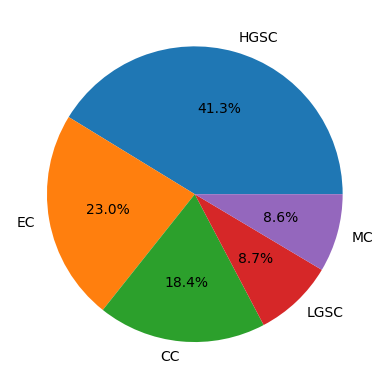

In [187]:
# Comptez combien de fois chaque catégorie apparaît dans la colonne 'label'
label_counts = data['label'].value_counts()

# Créez un pie chart en utilisant les données de 'label_counts'
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.show()

# 2-HGSC best image (for normalization)

# 3-Normalization function

In [188]:
# Normalization function (input : image - output : np.array)
def normalization_processing_np_np(np_image):
    # Appliquer une normalisation de l'image sur le modèle d'une image de référence ref_path
    ref_path = r"/kaggle/input/UBC-OCEAN/train_thumbnails/12522_thumbnail.png"

    # Charger l'image en couleur
    ref_img = cv2.imread(ref_path, cv2.IMREAD_COLOR)
        
    #image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Resize des images pour avoir la même taille
    ref_img = cv2.resize(ref_img, (256, 256), interpolation=cv2.INTER_AREA)
    
    image = cv2.resize(np_image, (256, 256), interpolation=cv2.INTER_AREA)

    # Appliquer la normalisation
    aft_img = match_histograms(image, ref_img)

    # Convert the image to uint8 and BGR
    aft_img = cv2.convertScaleAbs(aft_img, cv2.COLOR_LAB2BGR)

    return aft_img

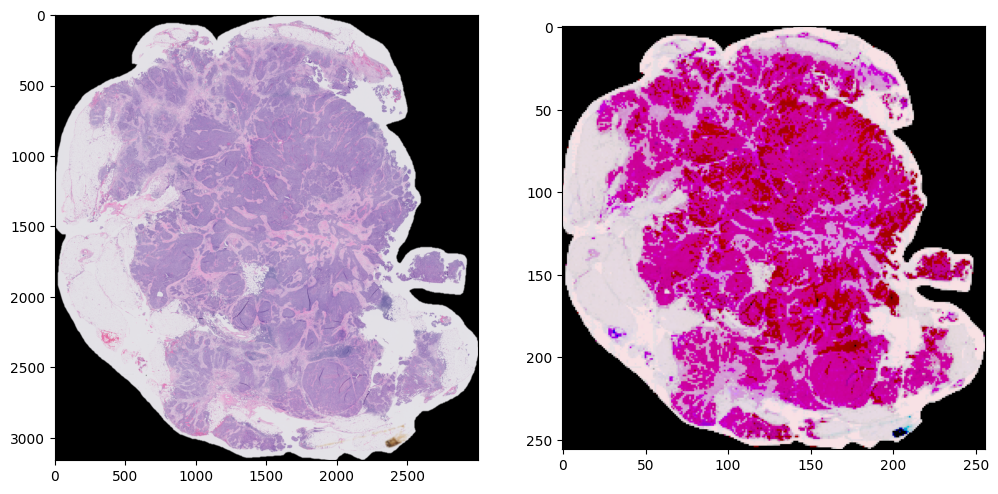

In [189]:
# Example of an image Before and After normalization
image_path = '/kaggle/input/UBC-OCEAN/train_thumbnails/10143_thumbnail.png'
np_image = cv2.imread(image_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(plt.imread(image_path))

ax[1].imshow(normalization_processing_np_np(np_image))

plt.show()

# Tiling function

In [190]:
# Tiling function
def tiling_np_np(image_array, tile_size=25, pix_threshold=100):
    # pix_threshold must be between 0 and 255, the higher the more discriminating
    def pad_to_size(tile, target_size):
        # Calcule la quantité de padding nécessaire
        pad_height = max(0, target_size[0] - tile.shape[0])
        pad_width = max(0, target_size[1] - tile.shape[1])

        # Ajoute des colonnes de zéros à gauche et à droite
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        # Ajoute des lignes de zéros en haut et en bas
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top

        # Applique le padding
        padded_tile = np.pad(tile, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)

        return padded_tile
    tiles = [pad_to_size(image_array[i:i+tile_size, j:j+tile_size], (tile_size, tile_size, 3)) for i in range(0, image_array.shape[0], tile_size) for j in range(0, image_array.shape[1], tile_size)]
    #print(tiles)
    # 4. Élimination des carreaux de taille inférieure à un certain threshold
    threshold = pix_threshold * tile_size**2 * 3 # Vous pouvez ajuster ce seuil en fonction de vos besoins
    filtered_tiles = [tile for tile in tiles if np.sum(tile) > threshold]

    # 5. Reconstruction d'un numpy array carré avec les tiles restant
    num_tiles_side = int(np.sqrt(len(filtered_tiles)))

    if (len(filtered_tiles) - num_tiles_side**2) != 0:
        num_blank_tiles = (num_tiles_side+1)**2 - num_tiles_side**2
        num_tiles_side = num_tiles_side + 1
    else:
        num_blank_tiles = 0

    # Création de tiles blancs
    blank_tile = np.zeros((tile_size, tile_size, 3), dtype=np.uint8)

    # Remplissage des tiles manquants avec des tiles blanches
    filled_tiles = filtered_tiles + [blank_tile] * num_blank_tiles

    # Reconstruction du numpy array carré
    reconstructed_array = np.vstack([np.hstack(filled_tiles[i*num_tiles_side:(i+1)*num_tiles_side]) for i in range(num_tiles_side)])

    # 6. Enregistrement au format png
    #reconstructed_image = Image.fromarray(reconstructed_array)
    reconstructed_image = cv2.convertScaleAbs(reconstructed_array, cv2.COLOR_LAB2BGR)
    reconstructed_image = cv2.resize(reconstructed_image, (256, 256), interpolation=cv2.INTER_AREA)

    #base_name = os.path.basename(image_path)
    # Create the folder if it doesn't exist
    #os.makedirs(r"reconstructed/", exist_ok=True)
    #folder = r"reconstructed/"
    #full_name = ''.join([folder, base_name])
    #reconstructed_image.save(full_name)
    return reconstructed_image
    #return reconstructed_array

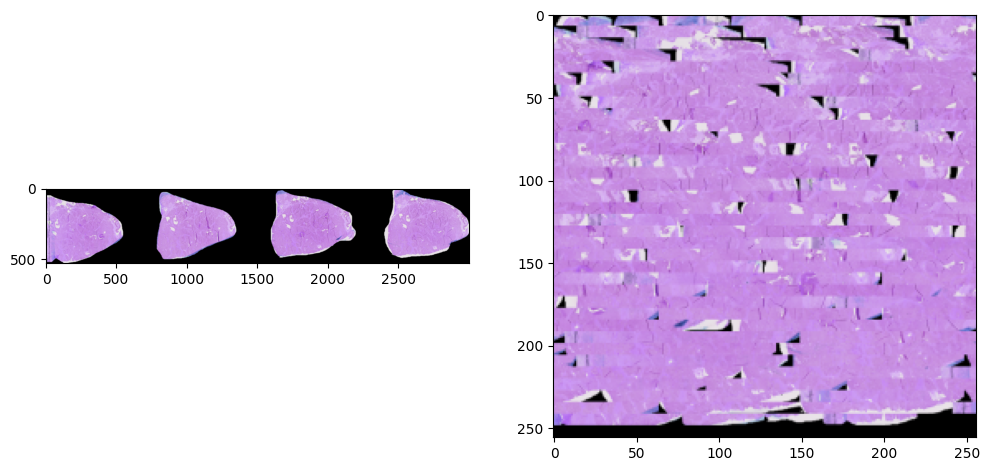

In [191]:
# Example of an image Before and After normalization
image_path = '/kaggle/input/UBC-OCEAN/train_thumbnails/5251_thumbnail.png'
image_array = cv2.imread(image_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(cv2.imread(image_path))

ax[1].imshow(tiling_np_np(image_array))

plt.show()

# Tiling and normalizing function

In [192]:
def tiling_and_normalization_pipeline(image_array):
    # Charger l'image
    #image_array = cv2.imread(image_path)

    # Appliquer la fonction de tuilage
    tiled_image = tiling_np_np(image_array)

    # Appliquer la fonction de normalisation
    normalized_image = normalization_processing_np_np(tiled_image)

    return normalized_image

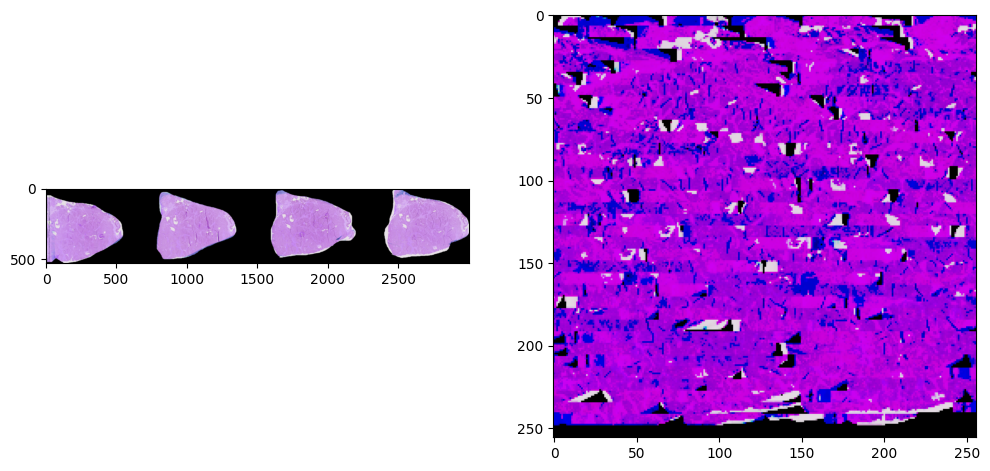

In [193]:
# Example of an image Before and After normalization
image_path = '/kaggle/input/UBC-OCEAN/train_thumbnails/5251_thumbnail.png'
image_array = cv2.imread(image_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(cv2.imread(image_path))

ax[1].imshow(tiling_and_normalization_pipeline(image_array))

plt.show()

# Model preparation

In [194]:
# Step parameter definition
epochs_dic = {1:1, 2:15, 3:30}
batch_size_dic = {1:16, 2:32, 3:64}
optimizer_dic = {1:'Adam', 2:'rmsprop'}
normalization_dic = {1:None, 2:'CC', 3:'EC', 4:'HGSC', 5:'LGSC', 6:'MC'}
tiling_dic = {1:None, 2:True}
label_dic = {1:['CC', 'EC', 'HGSC', 'LGSC', 'MC'], 2:['HGSC', 'Others']}
preprocessing_input_dic = {1:preprocess_input, 2:normalization_processing_np_np, 3:tiling_np_np, 4:tiling_and_normalization_pipeline}

In [195]:
# Step class management (to be reviewed !)
# Number of classes
nb_lab = len(data['label'].unique())

# Class list
le = LabelEncoder()
le.fit_transform(data['label'])
list_lab = le.classes_

In [196]:
# Data augmentation function for train-val
def data_flow_fct(data, datagen, data_type=None, batch_size=None) :

    data_flow = datagen.flow_from_dataframe(data,
                                            #directory=dir_, # Pas besoin
                                            x_col='image_path',  # Utilisez 'image_path' comme colonne des chemins d'images
                                            y_col='label',#_name',
                                            weight_col=None,
                                            target_size=(256, 256),
                                            classes=None,
                                            class_mode='categorical',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=42,
                                            subset=data_type)
    return data_flow

In [197]:
# Data augmentation function
def datagen_trainer(preprocessing_input):
    datagen_train = ImageDataGenerator(
    #    featurewise_center=True,
    #    featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.25,# détermine le ration training/validation
        preprocessing_function=preprocessing_input)
    return datagen_train

def datagen_tester(preprocessing_input):
    datagen_test = ImageDataGenerator(
        validation_split=0,
        preprocessing_function=preprocess_input)
    return datagen_test

In [198]:
# Model creation function
def create_model_fct(nb_lab) :
    #weights_path = "/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5" # ATTENTION : activer hors connexion
    weights_path = 'imagenet'
    # Charger le modèle VGG16 pré-entraîné
    #base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model0 = VGG16(include_top=False, weights=weights_path, input_shape=(256, 256, 3)) # ATTENTION : activer hors connexion
    
    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(nb_lab, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer_dic[1], metrics=["accuracy"])

    print(model.summary())
    
    return model

# Training

In [199]:
# Step flow definition
def define_flow(preprocessing_flow, batch_size_flow):
    # Data augmentation for train-val
    train_flow = data_flow_fct(data, datagen_trainer(preprocessing_flow), data_type='training',batch_size=batch_size_flow)
    val_flow = data_flow_fct(data, datagen_trainer(preprocessing_flow), data_type='validation',batch_size=batch_size_flow)
    test_flow = data_flow_fct(data, datagen_tester(preprocessing_flow), data_type=None, batch_size=1)
    return train_flow, val_flow, test_flow

In [200]:
%%time
# Step model creation and training
def model_creation_training(i,train_flow, val_flow,epochs_entry):
    # 4min35 for epochs = 1 and batch_size = 32
    # Model creation and training
    with tf.device('/gpu:1'):

        # Model creation
        print('1/3-Model creation')
        model = create_model_fct(nb_lab)

        # Call back creation
        print('2/3-Callbacks')
        model_save_path = f"model_best_weights_{i}.h5"
        checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
        es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
        callbacks_list = [checkpoint, es]

        # Training
        print('3/3-Training')
        history = model.fit(train_flow, epochs=epochs_entry, 
                            steps_per_epoch=len(train_flow),
                            callbacks=callbacks_list, 
                            validation_data=val_flow,
                            validation_steps=len(val_flow),
                            verbose=1)
    return model, history

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 14.8 µs


In [201]:
%%time
# Step performance train_val
def performance_train_val(history, model, val_flow, batch_size_entry):
    # Performances
    print('1/6-val accuracy/epochs')
    show_history(history)
    plot_history(history, path=f"history_{1}.png")
    plt.close()

    print('2/6-predicting y_pred')
    #1min 28 for batch_size = 32
    y_pred = model.predict(val_flow, steps=len(val_flow), batch_size=batch_size_entry)

    print('3/6-getting y_val')
    nombre_total_val = len(val_flow) * batch_size_entry

    # Initialisation d'un tableau pour stocker les étiquettes réelles
    y_val = np.zeros((nombre_total_val, nb_lab))  

    # Itérer sur le générateur pour extraire les étiquettes réelles
    for i in range(len(val_flow)):
        _, batch_y_val = val_flow[i]  # Supposons que le générateur génère des paires (X_val, y_val)
        start_index = i * batch_size_dic[2]
        end_index = start_index + len(batch_y_val)
        y_val[start_index:end_index] = batch_y_val

    print('4/6-building the basic confusion matrix')
    # Obtenez les indices des classes prédites et réelles pour les échantillons disponibles
    y_val_indices = y_val.argmax(axis=1)[0:len(y_pred)]
    y_pred_indices = y_pred.argmax(axis=1)

    # Générer la matrice de confusion
    cm = confusion_matrix(y_val_indices, y_pred_indices)

    # Afficher la matrice de confusion
    print(cm)

    # Afficher le rapport de classification
    print("\n5/6-building the classification report")
    print(classification_report(y_val.argmax(axis=1)[0:len(y_pred)], y_pred.argmax(axis=1)))

    print('6/6-building the sns confusion matrix')
    # Finding the matching categorical labels for the numerical labels
    list_num_labels = sorted([x for x in set(y_val_indices)|set(y_pred_indices)])
    list_cat_labels = le.inverse_transform(list_num_labels)

    # Proceding with sns
    df_cm = pd.DataFrame(cm, index=list_cat_labels, columns=list_cat_labels)

    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(df_cm, annot=True, cmap="Blues")

    # Ajouter des étiquettes aux axes
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")

    plt.show()
    

CPU times: user 9 µs, sys: 1e+03 ns, total: 10 µs
Wall time: 15 µs


# Prediction

In [202]:
%%time
# Useless here because we nee to preprocess the pictures we go through a test_flow instead (plus, this function takes too much time !)
def image_prep_fct(data) :
    prepared_images = []
    for image_num in data['image_path'] :

        img = (load_img(image_num,
        target_size=(256, 256)))

        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocessing_input_dic[4](img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

CPU times: user 14 µs, sys: 1e+03 ns, total: 15 µs
Wall time: 21.2 µs


In [203]:
# Step performance test
# Performance
def performance_test(model, test_flow):
    print('getting y_pred')
    # Testing on whole dataset
    #y_pred = model.predict(images_np)
    y_pred = model.predict(test_flow, steps=len(test_flow), batch_size=1)

    print('4/6-building the basic confusion matrix')
    # get y_val and y_pred
    y_pred_indices = y_pred.argmax(axis=1)
    y_pred_cat = le.inverse_transform(y_pred_indices)

    y_val_cat = data['label'][0:len(y_pred_cat)]

    # Générer la matrice de confusion
    cm = confusion_matrix(y_val_cat, y_pred_cat)

    # Afficher la matrice de confusion
    print(cm)

    # Afficher le rapport de classification
    print("\n5/6-building the classification report")
    print(classification_report(y_val_cat, y_pred_cat))

    print('6/6-building the sns confusion matrix')

    # Proceding with sns
    df_cm = pd.DataFrame(cm, index=label_dic[1], columns=label_dic[1])

    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(df_cm, annot=True, cmap="Blues")

    # Ajouter des étiquettes aux axes
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")

    plt.show()
    return y_val_cat, y_pred_cat

# Data Collection (for test)

Step 1 : class management (to be reviewed !)
Step 2 : flow definition
Found 20 validated image filenames belonging to 5 classes.
Found 6 validated image filenames belonging to 5 classes.
Found 26 validated image filenames belonging to 5 classes.
Step 3 : model creation and training
1/3-Model creation
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 19s 19s/step - loss: 4.6491 - accuracy: 0.2500 - val_loss: 4.0439 - val_accuracy: 0.3333
Step 4 : performance train_val
1/6-val accuracy/epochs


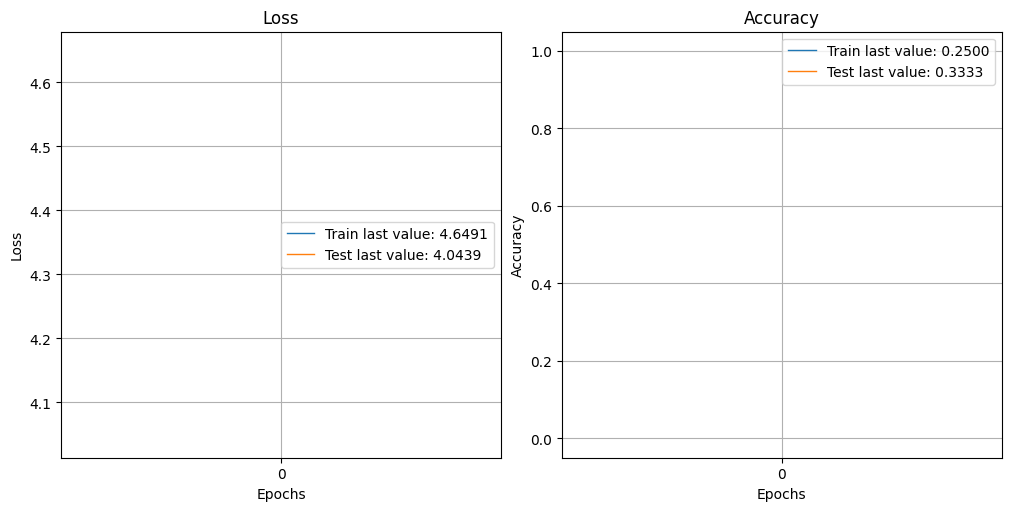

2/6-predicting y_pred
1/1 [==============================] - 4s 4s/step
3/6-getting y_val
4/6-building the basic confusion matrix
[[0 0 1]
 [0 0 3]
 [0 0 2]]

5/6-building the classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.33      1.00      0.50         2

    accuracy                           0.33         6
   macro avg       0.11      0.33      0.17         6
weighted avg       0.11      0.33      0.17         6

6/6-building the sns confusion matrix


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


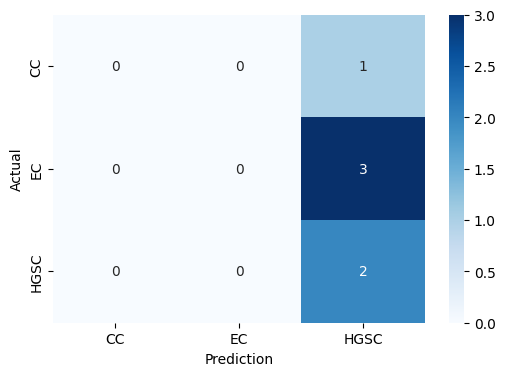

Step 6 : performance test
Get y_pred
26/26 [==============================] - 12s 461ms/step
4/6-building the basic confusion matrix
[[ 0  0  5  0  0]
 [ 0  0  6  0  0]
 [ 0  0 11  0  0]
 [ 0  0  2  0  0]
 [ 0  0  2  0  0]]

5/6-building the classification report
              precision    recall  f1-score   support

          CC       0.00      0.00      0.00         5
          EC       0.00      0.00      0.00         6
        HGSC       0.42      1.00      0.59        11
        LGSC       0.00      0.00      0.00         2
          MC       0.00      0.00      0.00         2

    accuracy                           0.42        26
   macro avg       0.08      0.20      0.12        26
weighted avg       0.18      0.42      0.25        26

6/6-building the sns confusion matrix


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


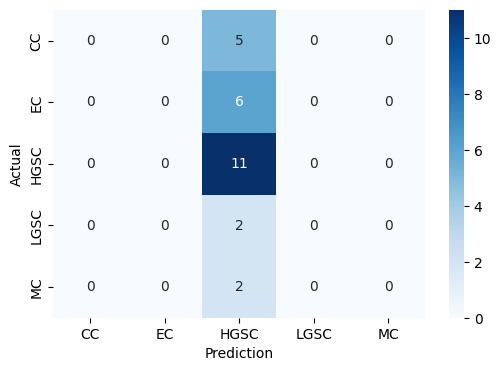

Step 7 : recording performance


,optimizer,method,val_accuracy,processing_time
0,Adam,preprocess_input,0.423077,55.92754


In [206]:
# Pipeline
# Step parameter definition
epochs_dic = {1:1, 2:15, 3:30}
batch_size_dic = {1:16, 2:32, 3:64}
optimizer_dic = {1:'Adam', 2:'rmsprop'}
normalization_dic = {1:None, 2:'CC', 3:'EC', 4:'HGSC', 5:'LGSC', 6:'MC'}
label_dic = {1:['CC', 'EC', 'HGSC', 'LGSC', 'MC'], 2:['HGSC', 'Others']}
preprocessing_input_dic = {1:preprocess_input, 2:normalization_processing_np_np, 3:tiling_np_np, 4:tiling_and_normalization_pipeline}

results = pd.DataFrame(columns=['optimizer','method','val_accuracy', 'processing_time'])
chrono = time()
for i in range(1,len(optimizer_dic)+1):
    for j in range(1,len(preprocessing_input_dic)+1):

        epochs_entry = epochs_dic[2]#15
        batch_size_entry = batch_size_dic[2]#32
        optimizer_entry = optimizer_dic[i]
        preprocessing_entry = preprocessing_input_dic[j]

        print('Step 1 : class management (to be reviewed !)')
        # Step class management (to be reviewed !)
        # Number of classes
        nb_lab = len(data['label'].unique())

        # Class list
        le = LabelEncoder()
        le.fit_transform(data['label'])
        list_lab = le.classes_

        print('Step 2 : flow definition')
        # Step flow definition
        train_flow, val_flow, test_flow = define_flow(preprocessing_entry, batch_size_entry)

        print('Step 3 : model creation and training')
        # Step model creation and training
        model, history = model_creation_training(i,train_flow, val_flow, epochs_entry)

        print('Step 4 : performance train_val')
        # Step performance train_val
        performance_train_val(history, model, val_flow, batch_size_entry)

        #print('Step 5 : préparation des images')
        # Step préparation des images (les images ne sont pas traitées !!)
        #images_np = image_prep_fct(data)
        #print(images_np.shape)

        print('Step 6 : performance test')
        # Step performance test
        y_val_cat, y_pred_cat = performance_test(model, test_flow)

        print('Step 7 : recording performance')
        chrono = time() - chrono
        results.loc[len(results)] = [optimizer_entry, preprocessing_entry.__name__, accuracy_score(y_val_cat, y_pred_cat), chrono]
        chrono = time()
results

# Pipeline